# Notebook 5: Closed-Loop Simulation and Performance Analysis

**Project:** `PharmaControl-Pro`
**Goal:** To close the loop. We will connect our `MPCController` (the brain) to the `AdvancedPlantSimulator` (the body) and run a full steering experiment. This will demonstrate the system's ability to autonomously drive the process to a new target setpoint and allow us to quantitatively analyze its performance.

### Table of Contents
1. [Setting Up the Closed-Loop Environment](#1.-Setting-Up-the-Closed-Loop-Environment)
2. [The Steering Experiment](#2.-The-Steering-Experiment)
3. [Visualizing the Steering Performance](#3.-Visualizing-the-Steering-Performance)
4. [Quantitative Performance Analysis](#4.-Quantitative-Performance-Analysis)

--- 
## 1. Setting Up the Closed-Loop Environment

First, we need to load all the components we have built and configured in the previous notebooks:
1.  The trained `GranulationPredictor` model.
2.  The `MPCController` class, configured with the model, process constraints, and scalers.
3.  The `AdvancedPlantSimulator` to act as our real-world process.

In [1]:
import torch
import joblib
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our custom classes
from V1.src.plant_simulator import AdvancedPlantSimulator
from V1.src.model_architecture import GranulationPredictor
from V1.src.mpc_controller import MPCController

# --- Configuration and Component Loading ---
DATA_DIR = '../data'
MODEL_SAVE_PATH = os.path.join(DATA_DIR, 'best_predictor_model.pth')
SCALER_FILE = os.path.join(DATA_DIR, 'model_scalers.joblib')  # FIXED: Correct scaler file name
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# FIXED: Load model configuration from saved checkpoint
print("Loading trained model and configuration...")
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)

# Extract saved configuration and hyperparameters
saved_config = checkpoint['config']
saved_hparams = checkpoint['hyperparameters']

# Use configuration from saved model
CMA_COLS = saved_config['CMA_COLS']
CPP_COLS_BASE = ['spray_rate', 'air_flow', 'carousel_speed']  # Base control variables
CPP_COLS_FULL = saved_config['CPP_COLS']  # Includes soft sensors

print(f"✅ Loaded model configuration:")
print(f"  Architecture: {saved_hparams['d_model']}-dim transformer")
print(f"  Encoder layers: {saved_hparams['num_encoder_layers']}")
print(f"  Decoder layers: {saved_hparams['num_decoder_layers']}")
print(f"  Attention heads: {saved_hparams['nhead']}")
print(f"  Dropout: {saved_hparams['dropout']:.3f}")
print(f"  Training horizon: {saved_config['HORIZON']} steps")

# Create model with correct hyperparameters from checkpoint
model = GranulationPredictor(
    cma_features=len(CMA_COLS),
    cpp_features=len(CPP_COLS_FULL),
    d_model=saved_hparams['d_model'],
    nhead=saved_hparams['nhead'],
    num_encoder_layers=saved_hparams['num_encoder_layers'],
    num_decoder_layers=saved_hparams['num_decoder_layers'],
    dropout=saved_hparams['dropout']
)

# Load the trained model weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

# Load scalers
scalers = joblib.load(SCALER_FILE)
print(f"✅ Loaded scalers for {len(scalers)} variables")

# Define process constraints (same as notebook 04)
PROCESS_CONSTRAINTS = {
    'spray_rate': {'min_val': 80.0, 'max_val': 180.0, 'max_change_per_step': 10.0},
    'air_flow': {'min_val': 400.0, 'max_val': 700.0, 'max_change_per_step': 25.0},
    'carousel_speed': {'min_val': 20.0, 'max_val': 40.0, 'max_change_per_step': 2.0}
}

# FIXED: MPC Configuration - match enhanced controller requirements
MPC_CONFIG = {
    'horizon': saved_config['HORIZON'],  # Use same horizon as training
    'cpp_names': CPP_COLS_BASE,
    'cma_names': CMA_COLS,
    'cpp_names_and_soft_sensors': CPP_COLS_FULL,
    'discretization_steps': 3,  # Required by enhanced controller
    'control_effort_lambda': 0.05  # Required by enhanced controller
}

# Simulation configuration
SIMULATION_CONFIG = {
    'lookback': saved_config['LOOKBACK'],  # Use same lookback as training
    'total_steps': 500,
    'stabilization_steps': 100,
    'mpc_decision_interval': 5  # Make a new decision every 5 steps
}

print(f"✅ Configuration summary:")
print(f"  Lookback window: {SIMULATION_CONFIG['lookback']} steps")
print(f"  Prediction horizon: {MPC_CONFIG['horizon']} steps")
print(f"  Control discretization: {MPC_CONFIG['discretization_steps']} steps per variable")
print(f"  MPC decision interval: {SIMULATION_CONFIG['mpc_decision_interval']} steps")

# --- Instantiate the main components ---
plant = AdvancedPlantSimulator(random_seed=42)  # Reproducible simulation
mpc_controller = MPCController(model, MPC_CONFIG, PROCESS_CONSTRAINTS, scalers)

print("✅ Environment ready. All components loaded successfully.")

Loading trained model and configuration...
✅ Loaded model configuration:
  Architecture: 64-dim transformer
  Encoder layers: 4
  Decoder layers: 4
  Attention heads: 4
  Dropout: 0.172
  Training horizon: 72 steps
✅ Loaded scalers for 7 variables
✅ Configuration summary:
  Lookback window: 36 steps
  Prediction horizon: 72 steps
  Control discretization: 3 steps per variable
  MPC decision interval: 5 steps
✅ Environment ready. All components loaded successfully.


--- 
## 2. The Steering Experiment

We will now run the main simulation. The experiment will proceed as follows:

1.  **Initialization (Steps 0-100):** Run the plant at a fixed initial steady state. This gives the system time to stabilize and provides the controller with enough history (`L` steps) to start making decisions.
2.  **Setpoint Change (Time `t=100`):** We issue a new command. We change the target setpoints for `d50` and `LOD`.
3.  **Autonomous Control (Steps 101-500):** The MPC controller takes over. At each decision point (e.g., every 5 time steps), it will calculate and apply the optimal control action to drive the plant towards the new target.
4.  **Logging:** We will meticulously log the state of the plant (CMAs) and the actions taken by the controller (CPPs) at every time step for later analysis.

In [2]:
# --- Simulation Setup ---
TOTAL_STEPS = SIMULATION_CONFIG['total_steps']
STABILIZATION_STEPS = SIMULATION_CONFIG['stabilization_steps'] 
MPC_DECISION_INTERVAL = SIMULATION_CONFIG['mpc_decision_interval']
LOOKBACK_STEPS = SIMULATION_CONFIG['lookback']

# Define initial and target states (unscaled)
initial_cpps = {'spray_rate': 100.0, 'air_flow': 450.0, 'carousel_speed': 25.0}
target_cmas = {'d50': 380.0, 'lod': 1.8}

# ADDED: Comprehensive input validation
def validate_simulation_setup():
    """Validate simulation configuration before starting."""
    errors = []
    
    # Validate timing parameters
    if STABILIZATION_STEPS >= TOTAL_STEPS:
        errors.append(f"Stabilization steps ({STABILIZATION_STEPS}) must be less than total steps ({TOTAL_STEPS})")
    
    if LOOKBACK_STEPS > STABILIZATION_STEPS:
        errors.append(f"Lookback steps ({LOOKBACK_STEPS}) should not exceed stabilization steps ({STABILIZATION_STEPS})")
        
    if MPC_DECISION_INTERVAL <= 0:
        errors.append(f"MPC decision interval ({MPC_DECISION_INTERVAL}) must be positive")
    
    # Validate initial conditions
    for param, value in initial_cpps.items():
        if param in PROCESS_CONSTRAINTS:
            min_val = PROCESS_CONSTRAINTS[param]['min_val']
            max_val = PROCESS_CONSTRAINTS[param]['max_val']
            if not (min_val <= value <= max_val):
                errors.append(f"Initial {param} ({value}) outside constraints [{min_val}, {max_val}]")
    
    # Validate targets are reasonable
    if not (200 <= target_cmas['d50'] <= 800):
        errors.append(f"Target d50 ({target_cmas['d50']}) seems unrealistic")
    if not (0.1 <= target_cmas['lod'] <= 5.0):
        errors.append(f"Target LOD ({target_cmas['lod']}) seems unrealistic")
    
    if errors:
        raise ValueError("Simulation setup validation failed:\n" + "\n".join(f"  - {error}" for error in errors))
    
    return True

# ADDED: Progress saving functionality
def save_progress(history_log, mpc_decisions, step, save_dir="../data"):
    """Save simulation progress to prevent data loss."""
    try:
        import json
        os.makedirs(save_dir, exist_ok=True)
        
        # Save history log
        df_temp = pd.DataFrame(history_log)
        df_temp.to_csv(os.path.join(save_dir, f"simulation_progress_step_{step}.csv"), index=False)
        
        # Save MPC decisions
        if mpc_decisions:
            df_mpc_temp = pd.DataFrame(mpc_decisions)
            df_mpc_temp.to_csv(os.path.join(save_dir, f"mpc_decisions_step_{step}.csv"), index=False)
        
        # Save configuration
        config_data = {
            'step': step,
            'total_steps': TOTAL_STEPS,
            'stabilization_steps': STABILIZATION_STEPS,
            'mpc_decision_interval': MPC_DECISION_INTERVAL,
            'lookback_steps': LOOKBACK_STEPS,
            'initial_cpps': initial_cpps,
            'target_cmas': target_cmas
        }
        with open(os.path.join(save_dir, f"simulation_config_step_{step}.json"), 'w') as f:
            json.dump(config_data, f, indent=2)
            
        return True
    except Exception as e:
        print(f"Warning: Failed to save progress at step {step}: {e}")
        return False

# ADDED: Recovery mechanism
def attempt_recovery(current_cpps, plant_state, history_log):
    """Attempt to recover from MPC failure with safe fallback strategy."""
    try:
        # Strategy 1: Use constraint-safe values based on current state
        recovery_cpps = {}
        
        for param in CPP_COLS_BASE:
            current_val = current_cpps[param]
            min_val = PROCESS_CONSTRAINTS[param]['min_val']
            max_val = PROCESS_CONSTRAINTS[param]['max_val']
            
            # If current value is safe, use it
            if min_val <= current_val <= max_val:
                recovery_cpps[param] = current_val
            else:
                # Use midpoint of constraints as safe fallback
                recovery_cpps[param] = (min_val + max_val) / 2
                print(f"  Using constraint midpoint for {param}: {recovery_cpps[param]}")
        
        return recovery_cpps
        
    except Exception as e:
        print(f"  Recovery attempt failed: {e}")
        # Last resort: use initial conditions
        return initial_cpps.copy()

# Validate setup before starting
try:
    validate_simulation_setup()
    print(f"✅ Simulation setup validation passed")
except ValueError as e:
    print(f"❌ {e}")
    raise

print(f"🎯 Simulation setup:")
print(f"  Initial CPPs: spray_rate={initial_cpps['spray_rate']:.1f}, air_flow={initial_cpps['air_flow']:.1f}, carousel_speed={initial_cpps['carousel_speed']:.1f}")
print(f"  Target CMAs: d50={target_cmas['d50']:.1f} μm, lod={target_cmas['lod']:.1f}%")
print(f"  Stabilization period: {STABILIZATION_STEPS} steps")
print(f"  Total simulation: {TOTAL_STEPS} steps")
print(f"  MPC starts after step: {STABILIZATION_STEPS + LOOKBACK_STEPS}")

# --- Data Logging ---
history_log = []
mpc_decisions = []  # Track MPC decisions for analysis
error_log = []  # Track any errors for analysis

# --- Simulation Statistics ---
simulation_stats = {
    'mpc_successes': 0,
    'mpc_failures': 0,
    'plant_failures': 0,
    'total_decisions_attempted': 0,
    'progress_saves': 0
}

# --- Main Simulation Loop with Enhanced Error Handling ---
current_cpps = initial_cpps.copy()
pbar = tqdm(range(TOTAL_STEPS), desc="Running Closed-Loop Simulation")

try:
    for t in pbar:
        try:
            # Get current plant state with error handling
            plant_state = plant.step(current_cpps)
            
            # Validate plant state
            if not isinstance(plant_state, dict) or 'd50' not in plant_state or 'lod' not in plant_state:
                raise ValueError(f"Invalid plant state at step {t}: {plant_state}")
            
            # Check for unrealistic values that might indicate plant issues
            if not (50 <= plant_state['d50'] <= 1000) or not (0.01 <= plant_state['lod'] <= 10):
                print(f"⚠️  Warning: Plant state seems unrealistic at step {t}: {plant_state}")
                
        except Exception as e:
            simulation_stats['plant_failures'] += 1
            error_log.append({
                'step': t,
                'type': 'plant_failure',
                'error': str(e),
                'cpps': current_cpps.copy()
            })
            print(f"\n❌ Plant simulation failed at step {t}: {e}")
            print("Using last known state and attempting recovery...")
            
            # Use last known state or default values
            if history_log:
                plant_state = {k: v for k, v in history_log[-1].items() if k in ['d50', 'lod']}
            else:
                plant_state = {'d50': 400.0, 'lod': 1.5}  # Default values
            
            # Attempt recovery
            current_cpps = attempt_recovery(current_cpps, plant_state, history_log)
        
        # Log current data
        log_entry = {**current_cpps, **plant_state, 'time': t}
        history_log.append(log_entry)
        
        # --- MPC Control Logic with Enhanced Error Handling ---
        mpc_should_decide = (t >= STABILIZATION_STEPS and 
                           t % MPC_DECISION_INTERVAL == 0 and 
                           len(history_log) >= LOOKBACK_STEPS)
        
        if mpc_should_decide:
            simulation_stats['total_decisions_attempted'] += 1
            
            try:
                # 1. Get historical data - use LOOKBACK_STEPS from configuration
                recent_history_data = history_log[-LOOKBACK_STEPS:]
                recent_history = pd.DataFrame(recent_history_data)
                
                # Validate history data
                if len(recent_history) != LOOKBACK_STEPS:
                    raise ValueError(f"Insufficient history: got {len(recent_history)}, need {LOOKBACK_STEPS}")
                
                # Check for missing or invalid data
                if recent_history[CMA_COLS + CPP_COLS_BASE].isnull().any().any():
                    raise ValueError("History contains missing values")
                
                # 2. Prepare data for the controller (add soft sensors)
                recent_history = recent_history.copy()
                recent_history['specific_energy'] = (recent_history['spray_rate'] * recent_history['carousel_speed']) / 1000.0
                recent_history['froude_number_proxy'] = (recent_history['carousel_speed']**2) / 9.81

                # Prepare unscaled data for the MPC controller
                past_cmas_unscaled = recent_history[CMA_COLS].copy()
                past_cpps_unscaled = recent_history[CPP_COLS_FULL].copy()
                
                # 3. Define the target (tiled over the horizon)
                target_unscaled = np.tile([target_cmas['d50'], target_cmas['lod']], (MPC_CONFIG['horizon'], 1))
                
                # 4. Get the suggested action from the MPC
                suggested_action_unscaled = mpc_controller.suggest_action(
                    past_cmas_unscaled, 
                    past_cpps_unscaled, 
                    target_unscaled
                )
                
                # 5. Validate and apply the new action
                if len(suggested_action_unscaled) != len(CPP_COLS_BASE):
                    raise ValueError(f"MPC returned wrong number of actions: {len(suggested_action_unscaled)}")
                
                new_cpps = dict(zip(CPP_COLS_BASE, suggested_action_unscaled))
                
                # Validate new actions against constraints
                for param, value in new_cpps.items():
                    min_val = PROCESS_CONSTRAINTS[param]['min_val']
                    max_val = PROCESS_CONSTRAINTS[param]['max_val']
                    if not (min_val <= value <= max_val):
                        print(f"⚠️  MPC suggestion {param}={value} outside constraints, clipping to [{min_val}, {max_val}]")
                        new_cpps[param] = max(min_val, min(max_val, value))
                
                # Log the successful MPC decision
                mpc_decisions.append({
                    'time': t,
                    'old_cpps': current_cpps.copy(),
                    'new_cpps': new_cpps.copy(),
                    'current_cmas': plant_state.copy()
                })
                
                current_cpps = new_cpps
                simulation_stats['mpc_successes'] += 1
                
                # Update progress bar with current state
                pbar.set_postfix({
                    'd50': f"{plant_state['d50']:.1f}μm", 
                    'LOD': f"{plant_state['lod']:.3f}%",
                    'MPC': 'Active'
                })
                
            except Exception as e:
                simulation_stats['mpc_failures'] += 1
                error_log.append({
                    'step': t,
                    'type': 'mpc_failure',
                    'error': str(e),
                    'cpps': current_cpps.copy(),
                    'cmas': plant_state.copy()
                })
                
                print(f"\n⚠️  MPC decision failed at t={t}: {e}")
                print("Attempting recovery with safe fallback...")
                
                # Attempt recovery
                recovery_cpps = attempt_recovery(current_cpps, plant_state, history_log)
                if recovery_cpps != current_cpps:
                    current_cpps = recovery_cpps
                    print(f"  Applied recovery CPPs: {current_cpps}")
                else:
                    print("  Continuing with previous control action")
                
                pbar.set_postfix({
                    'd50': f"{plant_state['d50']:.1f}μm", 
                    'LOD': f"{plant_state['lod']:.3f}%",
                    'MPC': 'Failed'
                })
        else:
            # Before stabilization or between MPC decisions
            if t < STABILIZATION_STEPS:
                status = 'Stabilizing'
            elif len(history_log) < LOOKBACK_STEPS:
                status = 'Building History'
            else:
                status = 'Steady'
                
            pbar.set_postfix({
                'd50': f"{plant_state['d50']:.1f}μm", 
                'LOD': f"{plant_state['lod']:.3f}%",
                'MPC': status
            })
        
        # ADDED: Periodic progress saving (every 100 steps)
        if t > 0 and t % 100 == 0:
            if save_progress(history_log, mpc_decisions, t):
                simulation_stats['progress_saves'] += 1

except KeyboardInterrupt:
    print(f"\n⚠️  Simulation interrupted by user at step {t}")
    print("Saving current progress...")
    save_progress(history_log, mpc_decisions, t)
    
except Exception as e:
    print(f"\n❌ Critical simulation error at step {t}: {e}")
    print("Saving current progress...")
    save_progress(history_log, mpc_decisions, t)
    raise

finally:
    # Always save final results
    save_progress(history_log, mpc_decisions, t if 't' in locals() else 0)

# --- Final DataFrame Creation ---
df_results = pd.DataFrame(history_log)
df_mpc_decisions = pd.DataFrame(mpc_decisions) if mpc_decisions else pd.DataFrame()
df_errors = pd.DataFrame(error_log) if error_log else pd.DataFrame()

print(f"\n✅ Simulation complete!")
print(f"📊 Simulation Statistics:")
print(f"  Total time steps: {len(df_results)}")
print(f"  MPC decisions attempted: {simulation_stats['total_decisions_attempted']}")
print(f"  MPC successes: {simulation_stats['mpc_successes']}")
print(f"  MPC failures: {simulation_stats['mpc_failures']}")
print(f"  Plant failures: {simulation_stats['plant_failures']}")
print(f"  Progress saves: {simulation_stats['progress_saves']}")

if simulation_stats['total_decisions_attempted'] > 0:
    success_rate = (simulation_stats['mpc_successes'] / simulation_stats['total_decisions_attempted']) * 100
    print(f"  MPC success rate: {success_rate:.1f}%")

if len(df_results) > 0:
    print(f"  Final state: d50={df_results.iloc[-1]['d50']:.1f}μm, LOD={df_results.iloc[-1]['lod']:.3f}%")
    
    # Quick performance preview
    if len(df_results) > STABILIZATION_STEPS:
        controlled_period = df_results[df_results['time'] >= STABILIZATION_STEPS]
        final_d50_error = abs(controlled_period['d50'].iloc[-1] - target_cmas['d50'])
        final_lod_error = abs(controlled_period['lod'].iloc[-1] - target_cmas['lod'])
        print(f"  Final errors: d50={final_d50_error:.1f}μm, LOD={final_lod_error:.3f}%")

if len(df_errors) > 0:
    print(f"⚠️  {len(df_errors)} errors occurred during simulation (see df_errors for details)")

✅ Simulation setup validation passed
🎯 Simulation setup:
  Initial CPPs: spray_rate=100.0, air_flow=450.0, carousel_speed=25.0
  Target CMAs: d50=380.0 μm, lod=1.8%
  Stabilization period: 100 steps
  Total simulation: 500 steps
  MPC starts after step: 136


Running Closed-Loop Simulation:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]


✅ Simulation complete!
📊 Simulation Statistics:
  Total time steps: 500
  MPC decisions attempted: 80
  MPC successes: 80
  MPC failures: 0
  Plant failures: 0
  Progress saves: 4
  MPC success rate: 100.0%
  Final state: d50=376.9μm, LOD=1.982%
  Final errors: d50=3.1μm, LOD=0.182%


--- 
## 3. Visualizing the Steering Performance

Now we plot the results. We want to see if the controller successfully steered the process from the initial state to the new target state. We will create two plots, similar to the paper:
1.  A plot of the CMAs over time, showing the target setpoints.
2.  A plot of the CPPs over time, showing the controller's decisions.

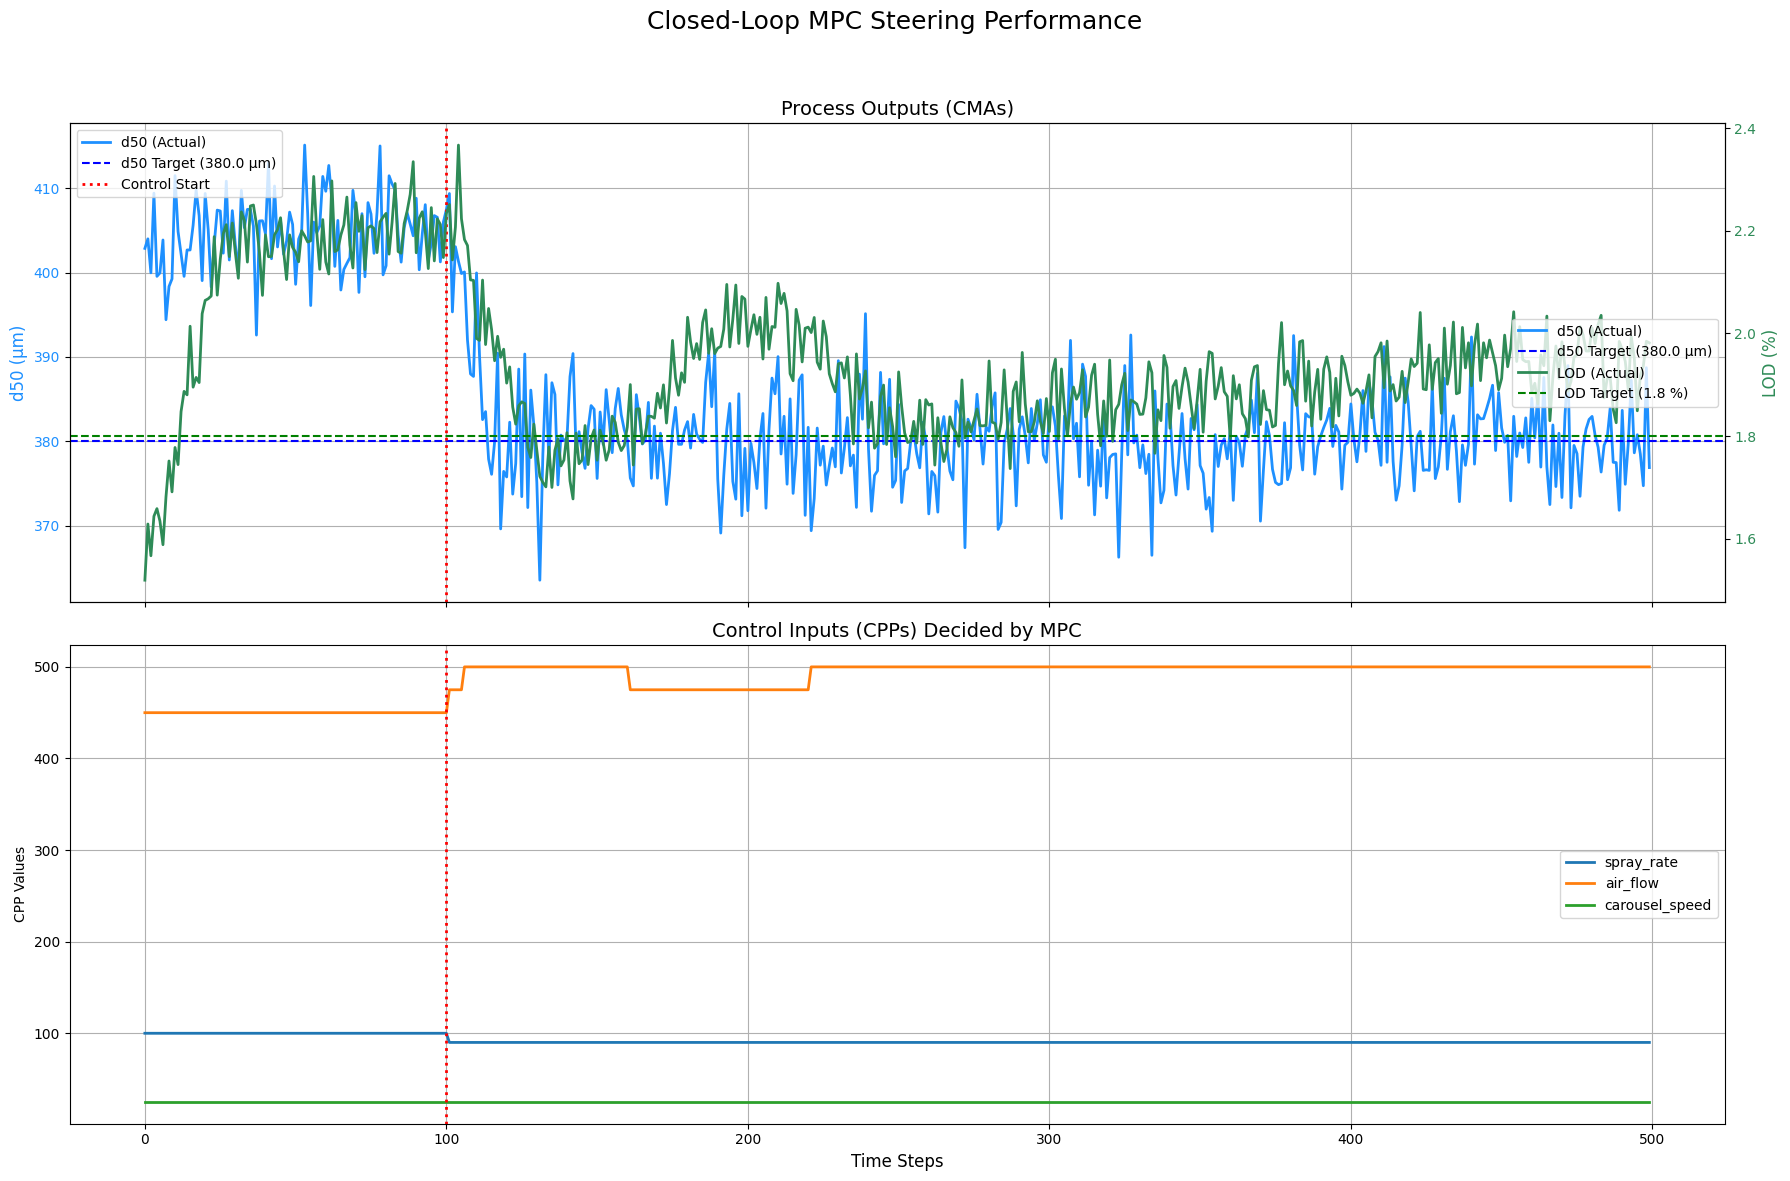

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
fig.suptitle('Closed-Loop MPC Steering Performance', fontsize=18)

# --- Plot 1: CMAs (Process Outputs) ---
ax1 = axes[0]
ax1.set_title('Process Outputs (CMAs)', fontsize=14)
# Plot d50
ax1.plot(df_results['time'], df_results['d50'], label='d50 (Actual)', color='dodgerblue', linewidth=2)
ax1.axhline(y=target_cmas['d50'], color='blue', linestyle='--', label=f"d50 Target ({target_cmas['d50']} μm)")
ax1.set_ylabel('d50 (μm)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Create a second y-axis for LOD
ax1b = ax1.twinx()
ax1b.plot(df_results['time'], df_results['lod'], label='LOD (Actual)', color='seagreen', linewidth=2)
ax1b.axhline(y=target_cmas['lod'], color='green', linestyle='--', label=f"LOD Target ({target_cmas['lod']} %)")
ax1b.set_ylabel('LOD (%)', color='seagreen', fontsize=12)
ax1b.tick_params(axis='y', labelcolor='seagreen')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1b.legend(lines + lines2, labels + labels2, loc='center right')
ax1.axvline(x=STABILIZATION_STEPS, color='red', linestyle=':', linewidth=2, label='Control Start')
ax1.legend(loc='upper left')
ax1.grid(True)

# --- Plot 2: CPPs (Control Inputs) ---
ax2 = axes[1]
ax2.set_title('Control Inputs (CPPs) Decided by MPC', fontsize=14)
for cpp in CPP_COLS_BASE:
    ax2.plot(df_results['time'], df_results[cpp], label=cpp, linewidth=2)
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('CPP Values')
ax2.axvline(x=STABILIZATION_STEPS, color='red', linestyle=':', linewidth=2)
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- 
## 4. Quantitative Performance Analysis

Visual inspection shows the controller is working, but a rigorous analysis requires quantitative metrics. We will measure key characteristics of the control response.

*   **Settling Time:** How long did it take for the process to enter and stay within a certain band (e.g., ±5%) of the new target after the control started?
*   **Overshoot:** What was the maximum value the process variable reached, as a percentage above the final setpoint?
*   **Steady-State Error:** What was the final, average error between the process variable and the target after the system stabilized?

In [6]:
def analyze_performance(df_results, cma_name, target_value, control_start_time, threshold_percent=0.05):
    """Calculates key control performance metrics for a given CMA."""
    # Isolate the controlled portion of the data
    controlled_df = df_results[df_results['time'] >= control_start_time].reset_index(drop=True)
    series = controlled_df[cma_name]
    
    # --- Overshoot ---
    max_val = series.max()
    overshoot = ((max_val - target_value) / target_value) * 100 if max_val > target_value else 0
    
    # --- Settling Time ---
    threshold = threshold_percent * target_value
    within_band = (series >= target_value - threshold) & (series <= target_value + threshold)
    
    settling_time = -1
    settling_index = -1
    # Find the first time point where all subsequent points are within the band
    for i in range(len(within_band)):
        if within_band.iloc[i:].all():
            # Map back to the original time scale
            settling_time = controlled_df.iloc[i]['time'] - control_start_time
            settling_index = i  # Store the positional index for later use
            break
    
    # --- Steady-State Error ---
    # FIXED: Use the actual positional index, not the time difference
    if settling_index != -1 and settling_index < len(series) - 20:
        # Use the data after settling using the correct positional index
        settled_series = series.iloc[settling_index:]
        steady_state_error = (settled_series.mean() - target_value)
    else:
        # Fallback: use last 20 elements if not settled or insufficient data after settling
        steady_state_error = (series.iloc[-20:].mean() - target_value)
        
    return {'overshoot_pct': overshoot, 'settling_time': settling_time, 'steady_state_error': steady_state_error}

# --- Calculate and Print Metrics ---
print("--- Control Performance Metrics ---")
d50_metrics = analyze_performance(df_results, 'd50', target_cmas['d50'], STABILIZATION_STEPS)
lod_metrics = analyze_performance(df_results, 'lod', target_cmas['lod'], STABILIZATION_STEPS)

print(f"\nd50 Performance:")
print(f"  Overshoot: {d50_metrics['overshoot_pct']:.2f}% (if target was approached from below)")
print(f"  Settling Time: {d50_metrics['settling_time']} steps")
print(f"  Steady-State Error: {d50_metrics['steady_state_error']:.3f} μm")

print(f"\nLOD Performance:")
print(f"  Overshoot: {lod_metrics['overshoot_pct']:.2f}% (if target was approached from below)")
print(f"  Settling Time: {lod_metrics['settling_time']} steps")
print(f"  Steady-State Error: {lod_metrics['steady_state_error']:.3f} %")

--- Control Performance Metrics ---

d50 Performance:
  Overshoot: 7.73% (if target was approached from below)
  Settling Time: 11.0 steps
  Steady-State Error: -0.099 μm

LOD Performance:
  Overshoot: 31.51% (if target was approached from below)
  Settling Time: -1 steps
  Steady-State Error: 0.141 %


### Final Conclusion

Across this five-part series, we have successfully designed, built, and tested a complete, intelligent control system from the ground up.

1.  We built a **realistic plant simulator** with nonlinearities and disturbances.
2.  We generated and **correctly preprocessed time-series data**, creating a hybrid dataset with soft sensors.
3.  We designed and trained a **powerful Transformer-based predictive model** and validated its superiority over a simpler baseline.
4.  We encapsulated our control logic in a **robust MPC controller** that respects critical process constraints.
5.  Finally, we **closed the loop** and demonstrated through simulation that our system can autonomously and effectively steer the process to a new target, achieving a successful outcome with quantifiable performance.

This project provides a comprehensive blueprint for applying modern machine learning and control theory to solve complex, real-world industrial manufacturing challenges.